# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import proplot as pplt
import pyextremes
import xarray as xr

In [2]:
import src.Teleconnection.tools as tools

# config

In [3]:
vertical_eof = 'dep'  # independently decompose each altitude levels
pattern = 'all'       # project onto the 'all' pattern (150 years and 100 ensemble members)

if vertical_eof == 'dep':
    folder = 'all_whole_std'
elif vertical_eof == 'ind':
    folder = 'ind_all_whole'

# read data

In [4]:
index = xr.open_dataset("/work/mh0033/m300883/3rdPanel/data/allPattern/"+vertical_eof+"/"+pattern+"_pattern/all_all_nonstd.nc")
index = tools.standardize(index)

In [5]:
index['time'] = index.indexes['time'].to_datetimeindex()

/tmp/ipykernel_2589576/251346105.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  index['time'] = index.indexes['time'].to_datetimeindex()


ensemble memeber as block, block maximum as extremes

In [6]:
from pyextremes import get_extremes, get_return_periods
from pyextremes import EVA

In [7]:
def return_period(index,extreme_type):
    """
    return return period given the extreme_type
    """
    # get the extremes

    if extreme_type == 'pos':
        extreme_type = 'high'
        extremes = index.max(dim = 'ens').to_dataframe()['pc']

    elif extreme_type == 'neg':
        extreme_type = 'low'
        extremes = index.min(dim = 'ens').to_dataframe()['pc']

    returnPeriod = get_return_periods(
        ts = extremes,
        extremes = extremes,
        block_size="365.2425D",
        return_period_size="365.2425D",
        plotting_position="cunnane",
        extremes_type = extreme_type,
        extremes_method = 'BM'
    )
    return returnPeriod

In [8]:
def median_return_period(d,method):
    """
    the median return period
    """
    ranks = d['return period'].rank(pct=True,method = method)
    close_to_median = abs(ranks - 0.5)
    return d.loc[[close_to_median.idxmin()],:]

In [9]:
def tenYear_return_period (return_periods):
    """
    split into first10 and last10
    """
    first10 = return_periods.loc['1850':'1860']
    last10 = return_periods.loc['1990':'1999']
    return first10,last10

In [10]:
def tenYear_return_period_median(all_return_period,method):
    """
    calculate the median of first10 and last10.
    """
    first10, last10 = tenYear_return_period(all_return_period)
    first10_median = median_return_period(first10,method = method)
    last10_median = median_return_period(last10,method = method)
    return first10_median, last10_median

In [11]:
def mode_return_period(index,mode, hlayers = 50000):
    
    index = index.sel(mode = mode,hlayers = hlayers)

    # pos
    all_pos = return_period(index,'pos')
    first10_all_pos, last10_all_pos = tenYear_return_period(all_pos)
    first10_median_pos, last10_median_pos = tenYear_return_period_median(all_pos,method = 'max')

    # neg
    all_neg = return_period(index,'neg')
    first10_all_neg, last10_all_neg = tenYear_return_period(all_neg)
    first10_median_neg, last10_median_neg = tenYear_return_period_median(all_neg,method = 'min')

    return first10_all_pos, last10_all_pos, first10_median_pos, last10_median_pos, first10_all_neg, last10_all_neg, first10_median_neg, last10_median_neg

In [12]:
EA_first10_all_pos, EA_last10_all_pos, EA_first10_median_pos, EA_last10_median_pos, EA_first10_all_neg, EA_last10_all_neg, EA_first10_median_neg, EA_last10_median_neg \
= mode_return_period(index,mode = 'EA',hlayers = 50000)

In [13]:
def plot_return_period(index,mode, hlayers = 50000):
    """
    return period plot
    """

    first10_all_pos, last10_all_pos, first10_median_pos, last10_median_pos, first10_all_neg, last10_all_neg, first10_median_neg, last10_median_neg\
        =mode_return_period(index, mode = mode, hlayers = hlayers)
    
    fig, axes = pplt.subplots(nrows = 1,ncols = 2, figwidth=8, span=False,share = False)

    axes.format(
        abc = 'a',
        abcloc = 'ul',
        xlim = (0,10),
        xminorlocator = 'null',
        yminorlocator = 'null',
        suptitle = f"return period of {mode} index at {hlayers/100:.0f}hpa",
        xlabel = "return period / yr",
        ylabel = "pc / std"
    )

    # pos
    axes[0].scatter(x = 'return period',y = 'pc', data = first10_all_pos,label = 'first10')
    axes[0].scatter(x = 'return period',y = 'pc', data = last10_all_pos,color = 'r',label = 'last10')

    axes[0].scatter(x = 'return period',y = 'pc', data = first10_median_pos,color = 'k',label = 'first10 median',marker = '+',s = 80)
    axes[0].scatter(x = 'return period',y = 'pc', data = last10_median_pos,color = 'k',label = 'last10 median',marker = "*",s = 80)

    # neg
    axes[1].scatter(x = 'return period',y = 'pc', data = first10_all_neg,label = 'first10')
    axes[1].scatter(x = 'return period',y = 'pc', data = last10_all_neg,color = 'r',label = 'last10')

    axes[1].scatter(x = 'return period',y = 'pc', data = first10_median_neg,color = 'k',label = 'first10 median',marker = '+',s = 80)
    axes[1].scatter(x = 'return period',y = 'pc', data = last10_median_neg,color = 'k',label = 'last10 median',marker = "*",s = 80)

    if mode == 'NAO':
        ix = axes[1].inset_axes(
            [6,-2.8,3.8,0.2],transform = 'data',zoom = False
        )
        ix.format(
            xlim = (0,300),
            ylim = (-4,-2.6),
            xminorlocator = 'null',
            yminorlocator = 'null',
            title = "zoom out"
        )
        ix.scatter(x = 'return period',y = 'pc', data = last10_all_neg,color = 'r')
        ix.set_xlabel(None)
        ix.set_ylabel(None)

    axes[0].legend(loc = 'lr',ncols = 1)

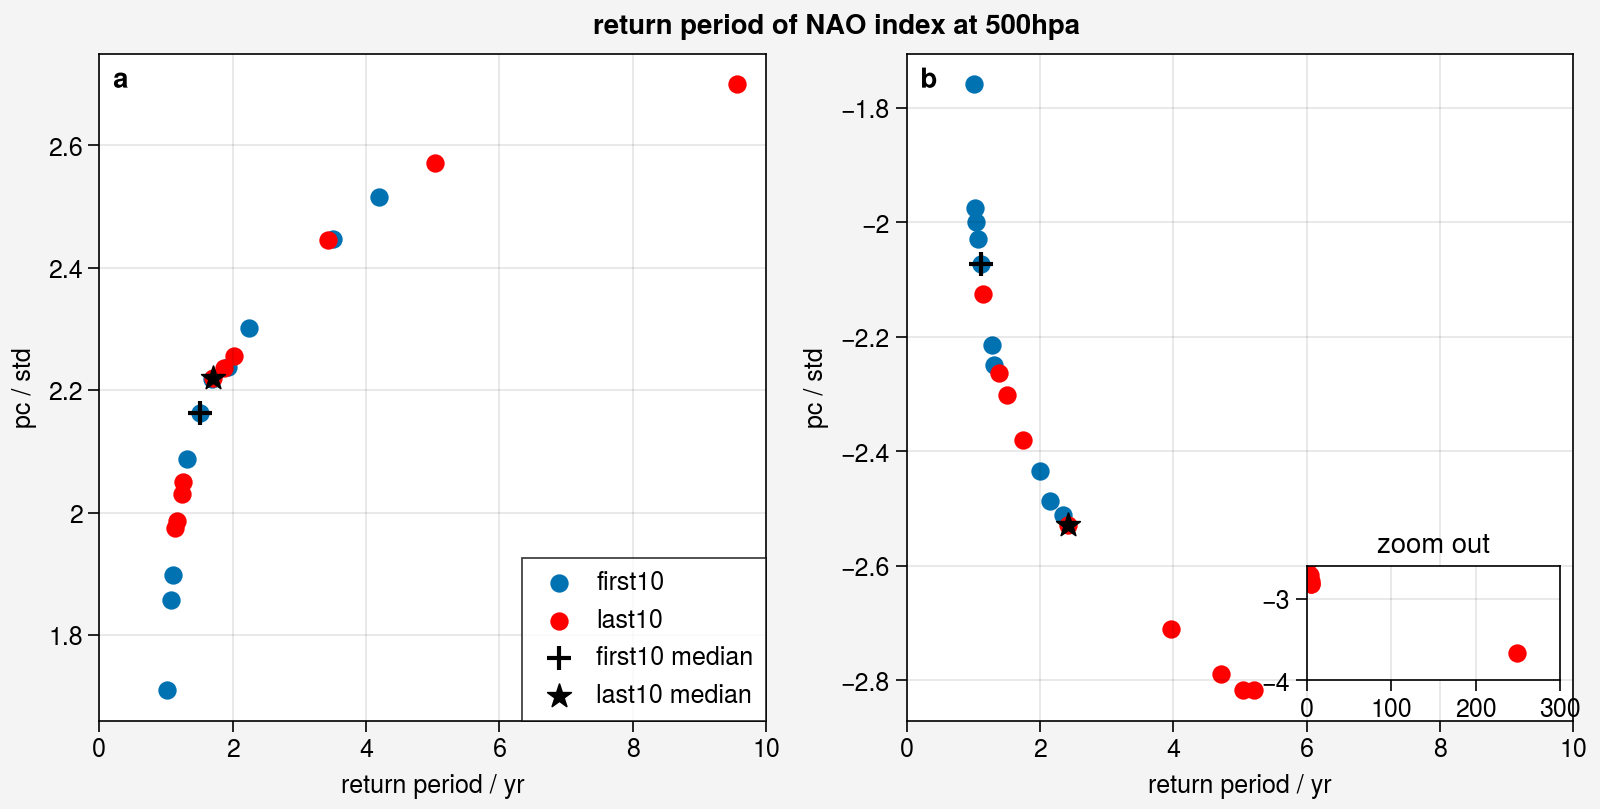

In [14]:
plot_return_period(index,"NAO")
plt.savefig("/work/mh0033/m300883/3rdPanel/docs/source/plots/first10_last10/"+folder+"/NAO_return_period.png")

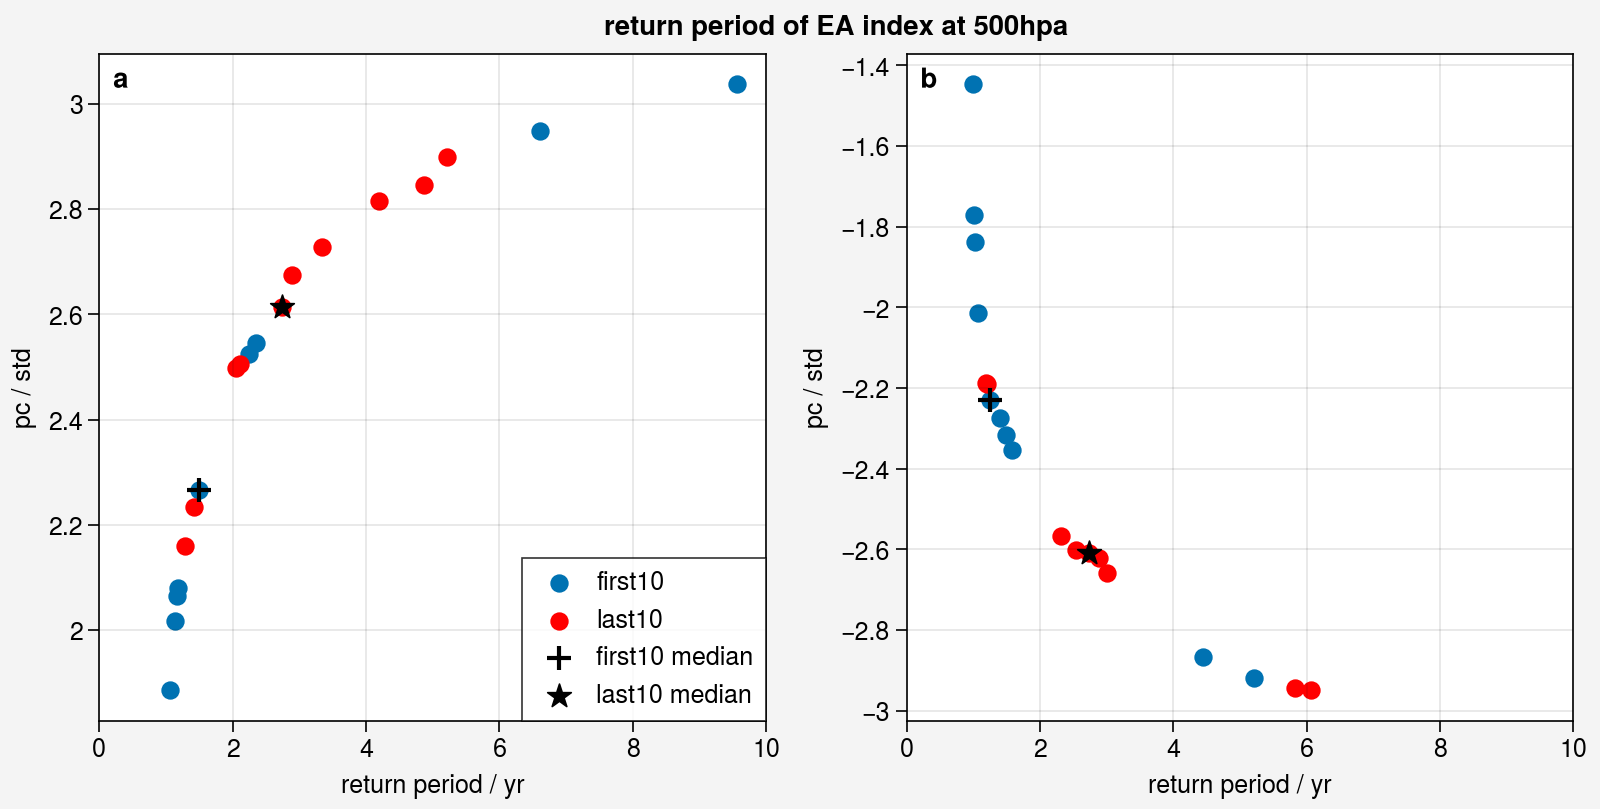

In [15]:
plot_return_period(index,"EA")
plt.savefig("/work/mh0033/m300883/3rdPanel/docs/source/plots/first10_last10/"+folder+"/EA_return_period.png")

## Vertical profile of median return period

NAO

In [16]:
def vertical_return_period(index,mode):
    pos = np.zeros((index.hlayers.size,2))
    neg = np.zeros((index.hlayers.size,2))

    for i, hlayers in enumerate(index.hlayers):
        _,_,POS_median_first,POS_median_last,_,_,NEG_median_first,NEG_median_last = mode_return_period(index, mode,hlayers)

        pos[i,0] = POS_median_first['return period'].values
        pos[i,1] = POS_median_last['return period'].values

        neg[i,0] = NEG_median_first['return period'].values
        neg[i,1] = NEG_median_last['return period'].values
    return pos, neg

In [17]:
NAO_pos,NAO_neg = vertical_return_period(index,'NAO')
EA_pos,EA_neg = vertical_return_period(index,'EA')

In [18]:
def plot_vertical_return_period(pos,neg,mode):
    fig, axes = pplt.subplots(nrows = 1,ncols = 2, figwidth=8, span=False,share = False)

    axes.format(
        abc = 'a',
        abcloc = 'ul',
        xlim = (0,5),
        xminorlocator = 'null',
        yminorlocator = 'null',
        suptitle = f"return period of {mode} index at 500hpa",
        xlabel = "return period / yr",
        ylabel = "gph/hpa",
        ylim = (1000,200)
    )


    y = index.hlayers.values/100
    axes[0].plot(pos[:,0],y,'k-',label = 'first10 median')

    axes[0].plot(pos[:,1],y,'k--',label = 'last10 median')


    axes[1].plot(neg[:,0],y,'k-',label = 'first10 median')
    axes[1].plot(neg[:,1],y,'k--',label = 'last10 median')

    axes[1].set_xlim(0,5)
    axes[0].set_xlim(0,5)

    axes[0].legend(loc = 'lr',ncols = 1)
    axes[1].legend(loc = 'lr',ncols = 1)


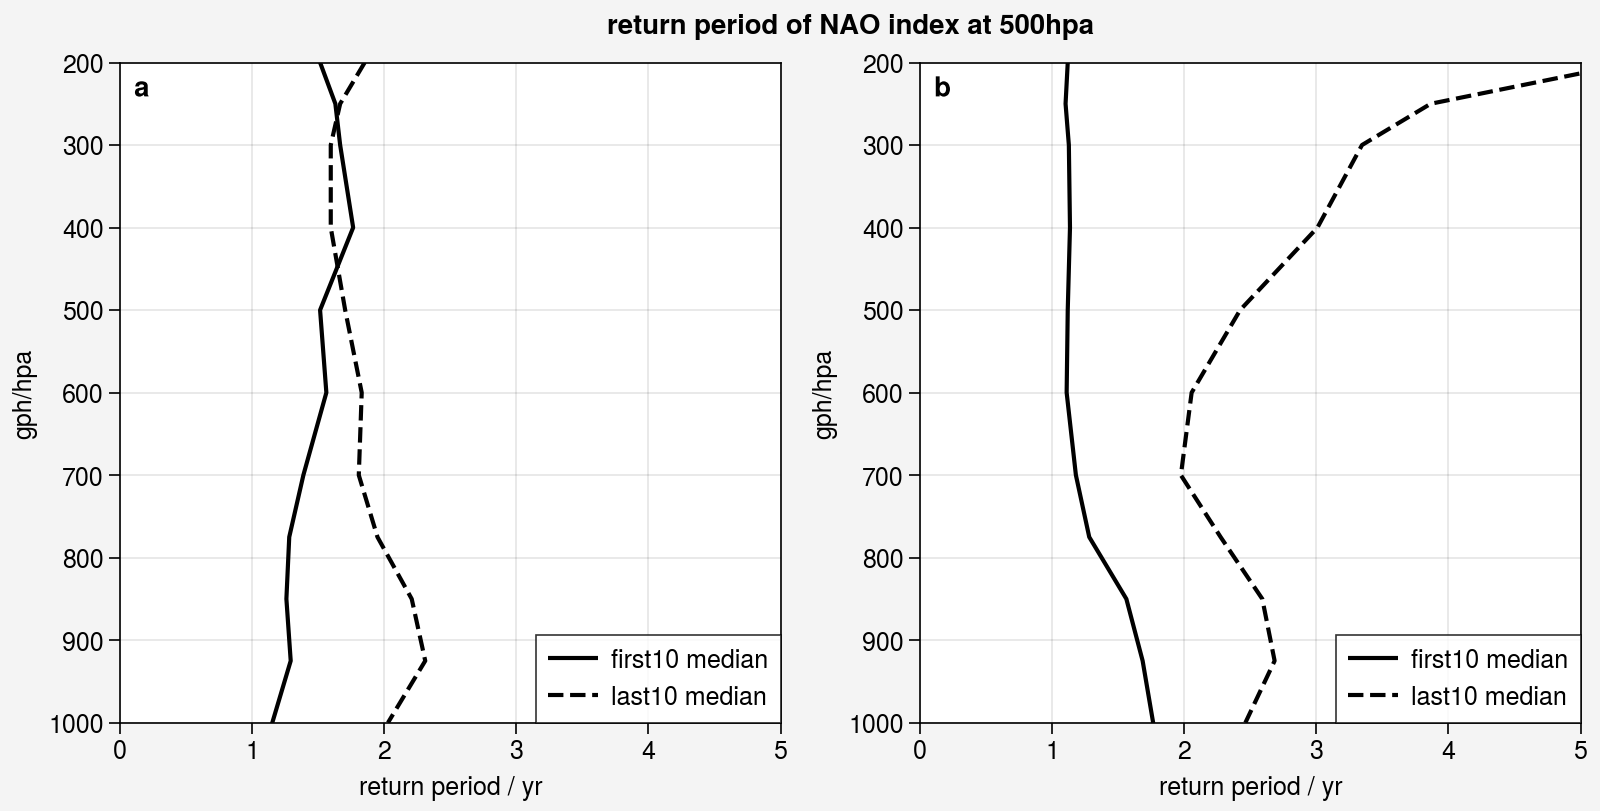

In [19]:
plot_vertical_return_period(NAO_pos,NAO_neg,'NAO')
plt.savefig("/work/mh0033/m300883/3rdPanel/docs/source/plots/first10_last10/"+folder+"/NAO_return_period_vertical.png")

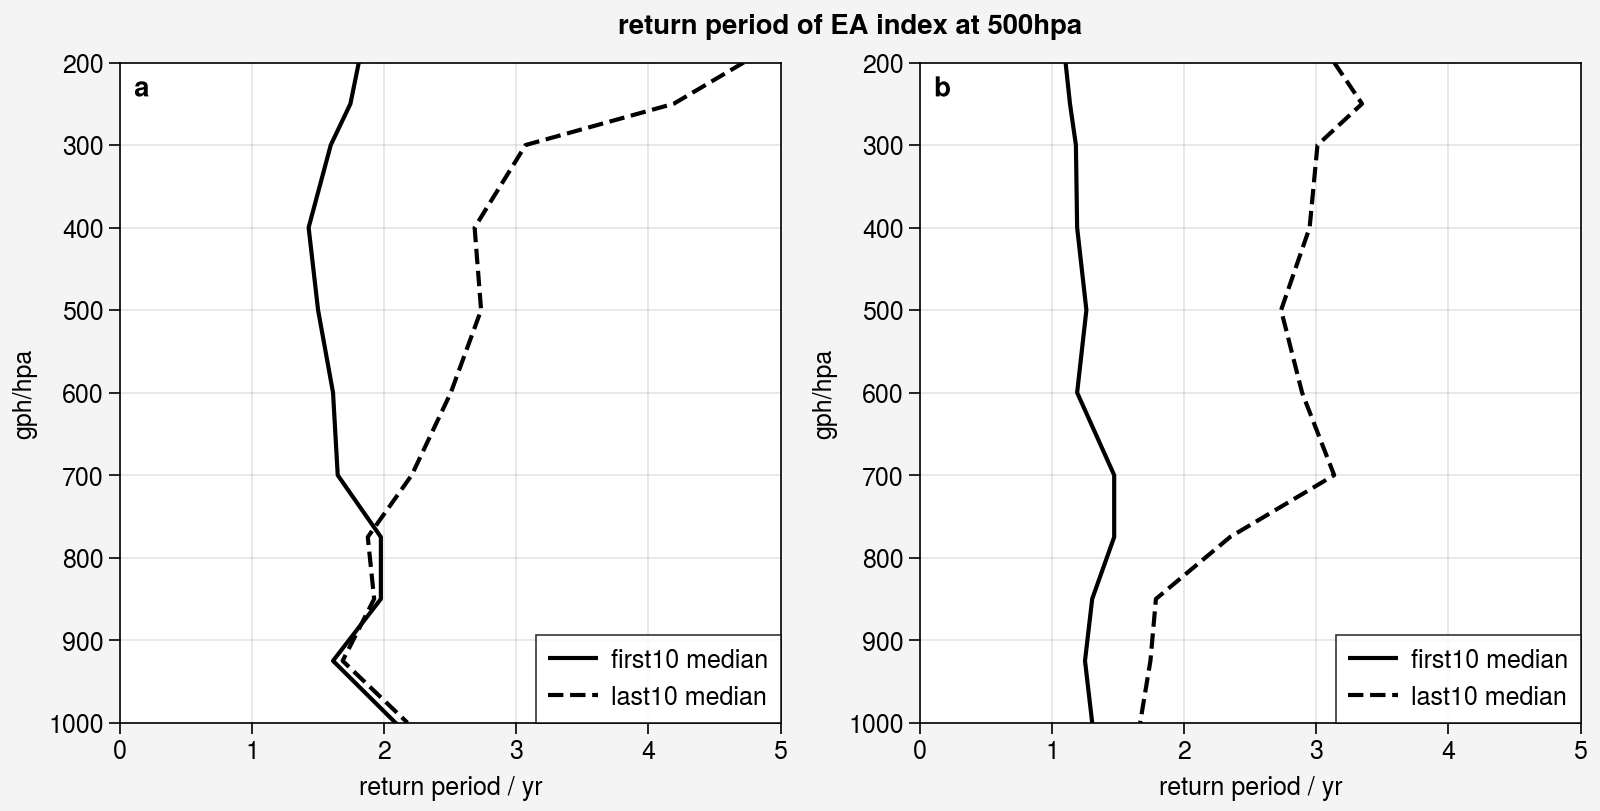

In [20]:
plot_vertical_return_period(EA_pos,EA_neg,'EA')
plt.savefig("/work/mh0033/m300883/3rdPanel/docs/source/plots/first10_last10/"+folder+"/EA_return_period_vertical.png")